# Convoutional Neural Networks
In 2012 every computer vision researcher encountered a jaw dropping moment! When AlexNet reduced the Top-5 error rate in the imagenet competition from 26% to 15.3%. But what was so special about it! It was a neural network that used a special kind of layer - Convolutional layer.

|![](https://predictiveprogrammer.com/wp-content/uploads/2018/06/convolve.gif)|
|:---------------------------------------------------------------------------:|
|*Convolutional Layer in action*|

Here, red green blue layers represent the RGB layers of an image. So how does the convolution works? and why is it so special?

## How Convolution layer works?

Convolution works as follows:
1. Start from top left corner of the image
2. Take a slice of image that is equal to the size of the kernel of the convolution layer. A kernel is a small tensor that finds hidden representation in the image.
3. Do element-wise multiplication of the image slice and the kernel
4. Sum over all the elements of the resulting tensor
5. Add it to the output tensor
6. Slide from current position on image to the left (or bottom if you are at the end of a row of image) by s.
7. Repeat steps 2 to 6 till you slide to bottom right corner of image.

For a detailed explanation of convolutional neural networks visit [this blog](https://predictiveprogrammer.com/convolutional-neural-networks-introduction/)

## Why are Convolution layers so special?
Convolution layers have special properties:
1. Translation Invariant: This means that they perform well even enough the object in image is moved from different parts of image:

  ![](https://qph.fs.quoracdn.net/main-qimg-ca754f61ff2dcf3080b4f5d39791e5f6)

2. Shared weights: The same kernel used on top left corner of the image is used all over the image again and again. So the number of weights, as opposed to dense layers, are very much less. For a solid example, visit [here](http://cs231n.github.io/assets/conv-demo/index.html)

## Padding, Pooling and more...
### Padding
Say you have a 10x10x3 image and you are passing it from a convolution layer with 1 kernel of size 3x3. Going by the process described above we will have an output of size 8x8x1 (1 representing the number of kernels applied in the convolution layer). But what if  we needed the output exactly equal to the input ,i.e. 10x10x1, how can we do it? This is where padding comes into play! We apply a zero padding to the image so that the output is similar to the input. For a detailed explanation see [here](https://predictiveprogrammer.com/convolutional-neural-networks-introduction/#padding)

### Pooling
Sometimes we just have to reduce the number of pixels we are dealing with. But we need to do it intelligently, retaining vital information about the data. We can do it using pooling layers. An example of a max pooling layer, that takes the maximum value from a 2x2 grid of the image:

|![](https://predictiveprogrammer.com/wp-content/uploads/2018/06/maxpool.gif)|
|:-:|
|*Max Pooling layer in action*|

For a detailed explantion see [here](https://predictiveprogrammer.com/convolutional-neural-networks-introduction/#pooling)

### Non-Linearities
All the operations we performed required some basic multiplications and additions which didn’t add any non-linearity to our input. However, data, as we know, is not a linear quantity. Our world is full of non-linearities! To really predict a value which is dependent on non-linear data, we need to catch the point of separation between these non-linear data points. We achieve this by utilizing some famous non-linear functions (aka activation functions).

|![](https://predictiveprogrammer.com/wp-content/uploads/2018/06/activations.png)|
|:-:|
|*Some activation functions*|

Now that we are done with theory. Let's start with building our own CNN!

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from IPython import display

%matplotlib inline

In [2]:
tf.__version__

'1.10.0'

In [3]:
tf.enable_eager_execution()

Let's define some functions which will help us further down the lane.

* `train_val_split(...)` will help us split data for validation!
* `shuffle(...)` will be used to shuffle data before training!
* `plot_100_imgs(...)` is just for data visualization!
* `visualize(...)` is a visualization function that will be called after every epoch to print training stats!

In [4]:
def train_val_split(x, y, val_split=0.2):
    split = int(val_split * x.shape[0])
    return (x[split:], y[split:]), (x[:split], y[:split])

In [5]:
def shuffle(x, y):
    indices = np.random.permutation(np.arange(x.shape[0]))
    return x[indices], y[indices]

In [6]:
def plot_100_imgs(imgs):
    plt.figure(figsize=(7, 7))
    img_indices = np.random.permutation(np.arange(imgs.shape[0]))[:100]
    for i, index in enumerate(img_indices):
        plt.subplot(10, 10, i+1)
        plt.imshow(imgs[index], cmap='binary')
        plt.axis('off')
    plt.tight_layout()

In [7]:
def visualize_helper(d1, d2, label1, label2, xlabel, ylabel):
    # helper function for visualize function
    plt.plot(range(1, len(d1)+1), d1, label=label1)
    plt.plot(range(1, len(d2)+1), d2, label=label2)

    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    ymin, ymax = plt.ylim()

    ymin = 0
    # remove outliers and view only data that is
    # 1 standard deviation away from mean
    # (Considering it a normal distribution. 
    # That might not be the case, but it still is a good way to remove outliers (^_^) )
    if len(d1) > 1:
        ymin1 = np.mean(d1) - np.std(d1)
        ymin2 = np.mean(d2) - np.std(d2)
        ymin = min(ymin1, ymin2)

        ymax1 = np.mean(d1) + np.std(d1)
        ymax2 = np.mean(d2) + np.std(d2)
        ymax = max(ymax1, ymax2)
    plt.ylim(ymin, ymax)

def visualize(l_history, a_history, val_l_history, val_a_history):
    plt.figure(figsize=(10, 4))
    plt.suptitle('TRAINING STATS')

    plt.subplot(121)
    plt.title('Loss')
    visualize_helper(l_history, val_l_history, 'loss', 'val_loss', 'Epoch', 'Loss')
    plt.legend()

    plt.subplot(122)
    plt.title('Accuracy')
    visualize_helper(a_history, val_a_history, 'accuracy', 'val_acc', 'Epoch', 'Accuracy')
    plt.legend()

    display.clear_output(wait=True)
    plt.show()

Let's load our dataset!

In [8]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

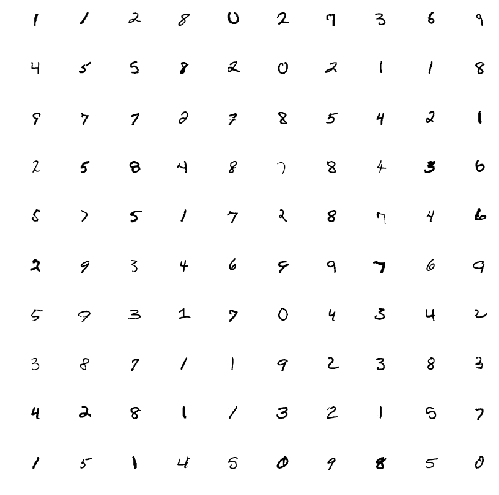

In [9]:
plot_100_imgs(X_train)

Now let's define our model!

We will be using `tf.keras.layers.Conv2D(...)`:
* filters: Number of kernels
* kernel_size: Size of kernel
* strides: stride size
* padding: 'same' or 'valid'
* activation: The activation function applied to output of the layer!

And `tf.keras.layers.MaxPool2D(...)`
* size: Window size of Pooling
* strides: stride size

In [10]:
# A 5 layer model.
# 4 convolutions and 1 dense
# using 2 max pooling layers to down sample data
# and using Flatten to convert tensor of images to 2D matrix.
# Each row representing a flattened image representation
model = tf.keras.models.Sequential([
    layers.Conv2D(32, 3, strides=1, padding='same', activation='relu'),
    layers.Conv2D(32, 3, strides=1, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3, strides=1, padding='same', activation='relu'),
    layers.Conv2D(64, 3, strides=1, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(10)
])

In [12]:
optimizer = tf.train.AdamOptimizer(LEARNING_RATE)

In [11]:
EPOCHS = 5
LEARNING_RATE = 1e-2
BATCH_SIZE = 32

Now that we have made our model. Let's make some functions that will help us at training time!

* `compute_loss(...)`: Compute loss, separately for training and testing time (depending on `training` param).
* `backprop(...)`: Apply gradient descent using `GradientTape` and `optimizer`

In [13]:
def compute_loss(model, x, y, training=True):
    # make predictions without softmax normalization
    logits = model(x.astype(np.float32), training=training)
    # Compute cost over each example
    costs = tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y, 10), logits=logits)
    # apply reduce mean to calculate total cost or loss
    loss = tf.reduce_mean(costs)
    return loss, logits

def backprop(model, loss, grad_tape, optimizer):
    # use gradient tape to calculate gradients
    grads = grad_tape.gradient(loss, model.variables)
    # apply gradients
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step=tf.train.get_or_create_global_step())

`iterate_over_data(...)`: A generic function for both training and testing period. Use `is_training` param to define whether you are training (`True`) or testing (`False`)

In [14]:
def iterate_over_data(X, Y, model, batch_size, optimizer=None, is_training=False):
    if is_training:
        assert optimizer is not None

    step_l_history = []
    step_a_history = []

    if is_training:
        pbar = tqdm(range(0, X.shape[0], batch_size))
    else:
        pbar = range(0, X.shape[0], batch_size)
    for batch_start in pbar:
        x_batch = np.expand_dims(X_train_[batch_start:batch_start + BATCH_SIZE], -1)
        y_batch = Y_train_[batch_start:batch_start + BATCH_SIZE]

        if is_training:
            with tf.GradientTape() as tape:
                loss, logits = compute_loss(model, x_batch, y_batch, training=True)
            backprop(model, loss, tape, optimizer)
        else:
            loss, logits = compute_loss(model, x_batch, y_batch, training=False)
        preds = tf.nn.softmax(logits)
        correct_preds = tf.equal(y_batch, tf.argmax(preds, -1))
        acc = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

        step_l_history.append(loss.numpy())
        step_a_history.append(acc.numpy())
    return np.mean(step_l_history), np.mean(step_a_history)

Training loop. We will collect data for every epoch and visualize it!

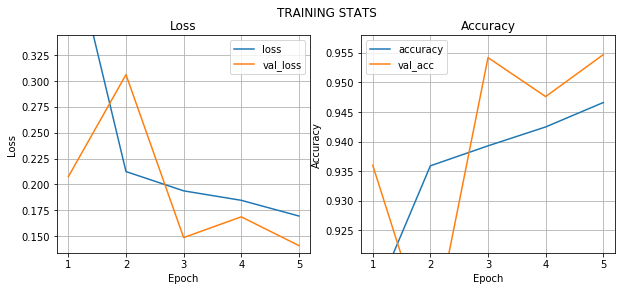

In [15]:
l_history = []
a_history = []

val_l_history = []
val_a_history = []

for i in range(EPOCHS):
    
    print('Epoch {}/{}'.format(i+1, EPOCHS))

    # Shuffle dataset
    X_train, Y_train = shuffle(X_train, Y_train)
    # split into training and validation data
    (X_train_, Y_train_), (X_val, Y_val) = train_val_split(X_train, Y_train)

    # iterate for training
    l, a = iterate_over_data(X_train_, Y_train_, model, BATCH_SIZE, optimizer, True)
    l_history.append(l)
    a_history.append(a)

    # iterate for testing
    l, a = iterate_over_data(X_val, Y_val, model, BATCH_SIZE, is_training=False)
    val_l_history.append(l)
    val_a_history.append(a)

    # visualization after each epoch!
    visualize(l_history, a_history, val_l_history, val_a_history)

This brings us to the end of this tutorial!

**There are CNNs that caused a jaw dropping scenarios. Learn more about them [here](https://predictiveprogrammer.com/famous-convolutional-neural-network-architectures-1/).**